In [1]:
import re, math, collections
from pathlib import Path

import json

import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
# nltk.download('punkt'); nltk.download('stopwords')   # first run only


In [2]:
DATA_DIR = Path(".")
PLAINTEXT_DIR = DATA_DIR / "plaintext_articles"
LINKS_TSV = DATA_DIR / "links.tsv"
ARTICLES_TSV = DATA_DIR / "articles.tsv"

assert PLAINTEXT_DIR.exists(), "folder plaintext_articles not found"
assert LINKS_TSV.exists(), "links.tsv not found"
assert ARTICLES_TSV.exists(), "articles.tsv not found"


In [3]:
TOKEN_RE = re.compile(r"[A-Za-z]{2,}")
STOPWORDS = set(stopwords.words("english"))
STEM = PorterStemmer().stem


def preprocess(text: str) -> list[str]:
    """Lower-case, tokenize, remove stop-words, apply Porter-stemmer."""
    return [STEM(tok) for tok in TOKEN_RE.findall(text.lower()) if tok not in STOPWORDS]


In [4]:
art_df = pd.read_csv(
    ARTICLES_TSV, sep="\t", header=None, names=["id", "title"], dtype=str
)
id2title = dict(zip(art_df.id, art_df.title))
valid_titles = {p.stem for p in PLAINTEXT_DIR.glob("*.txt")}


In [5]:
links_raw = pd.read_csv(
    LINKS_TSV, sep="\t", header=None, names=["src_raw", "dst_raw"], dtype=str
)


def to_title(x: str) -> str | None:
    if x in valid_titles:
        return x
    return id2title.get(x)  # None if id not found


links_df = links_raw.assign(
    src=links_raw.src_raw.map(to_title), dst=links_raw.dst_raw.map(to_title)
).dropna(subset=["src", "dst"])
links_df = links_df[
    links_df.src.isin(valid_titles) & links_df.dst.isin(valid_titles)
].loc[:, ["src", "dst"]]

print("edges kept:", len(links_df))


edges kept: 119882


In [6]:
from collections import defaultdict, Counter


def collect_200(query: str, limit: int = 200, mode: str = "OR"):
    q_terms = preprocess(query)
    docs, inv = [], defaultdict(set)
    tf, dl, df = {}, {}, defaultdict(int)

    for txt in PLAINTEXT_DIR.glob("*.txt"):
        if len(docs) >= limit:
            break
        doc_id = txt.stem
        tokens = preprocess(txt.read_text("utf-8", errors="ignore"))
        tok_set = set(tokens)
        cond = (
            any(t in tok_set for t in q_terms)
            if mode == "OR"
            else all(t in tok_set for t in set(q_terms))
        )
        if not cond:
            continue
        docs.append(doc_id)
        cnt = Counter(tokens)
        tf[doc_id] = cnt
        dl[doc_id] = len(tokens)
        for t, c in cnt.items():
            inv[t].add(doc_id)
        for t in tok_set:
            df[t] += 1

    N = len(docs)
    bm = dict(tf=tf, df=df, doc_len=dl, avg_dl=sum(dl.values()) / N if N else 0.0, N=N)
    return docs, bm


QUERY = "pictish kings and scottish history"
root_docs, bm_raw = collect_200(QUERY)
root_set = set(root_docs)
print("root-set size:", len(root_set))


root-set size: 200


In [7]:
def build_base(root: set[str]) -> set[str]:
    in_nei = links_df.loc[links_df.dst.isin(root), "src"]
    out_nei = links_df.loc[links_df.src.isin(root), "dst"]
    return set(root).union(in_nei).union(out_nei)


base_set = build_base(root_set)
print("base-set size:", len(base_set))


base-set size: 3108


In [8]:
def build_graph(base: set[str]):
    idx = {n: i for i, n in enumerate(base)}
    N = len(idx)

    mask = links_df.src.isin(base) & links_df.dst.isin(base)
    sub = links_df.loc[mask]
    s = sub.src.map(idx).to_numpy()
    d = sub.dst.map(idx).to_numpy()

    # adjacency (column j = links out of node j)
    A = sp.coo_matrix((np.ones_like(s, dtype=float), (d, s)), shape=(N, N)).tocsc()

    out_deg = np.bincount(s, minlength=N)
    in_deg = np.bincount(d, minlength=N)
    return idx, A, in_deg, out_deg, s, d


idx, A, in_deg, out_deg, s_idx, d_idx = build_graph(base_set)
N = len(idx)


In [9]:
def power(M: sp.csc_matrix, d: float = 0.85, tol: float = 1e-10, max_iter: int = 100):
    N = M.shape[0]
    pr = np.full(N, 1 / N)
    teleport = (1 - d) / N
    dangling = np.where(M.sum(axis=0).A.ravel() == 0)[0]

    for _ in range(max_iter):
        prev = pr.copy()
        pr = d * (M @ prev)
        if dangling.size:
            pr += d * prev[dangling].sum() / N
        pr += teleport
        if np.linalg.norm(pr - prev, 1) < tol:
            break
    return pr / pr.sum()


def wpr_matrix(N, s, d, in_deg, out_deg):
    sum_I = np.bincount(s, weights=in_deg[d], minlength=N)
    sum_O = np.bincount(s, weights=out_deg[d], minlength=N)

    data, rows, cols = [], [], []
    for si, di in zip(s, d):
        if sum_I[si] == 0 or sum_O[si] == 0:
            continue
        w = (in_deg[di] / sum_I[si]) * (out_deg[di] / sum_O[si])
        rows.append(di)
        cols.append(si)
        data.append(w)

    M = sp.coo_matrix((data, (rows, cols)), shape=(N, N)).tocsc()

    # dangling columns → uniform
    zero = np.where(M.sum(axis=0).A.ravel() == 0)[0]
    if zero.size:
        M[:, zero] = sp.csc_matrix(np.full((N, zero.size), 1 / N))

    # column-stochastic
    col_sum = np.asarray(M.sum(axis=0)).ravel()
    M.data /= col_sum[M.indices]
    return M


In [10]:
# classical PR matrix (column-normalised A)
col_sum = np.asarray(A.sum(axis=0)).ravel()
A_norm = A.copy()
A_norm.data /= col_sum[A_norm.indices]

pr_vec = power(A_norm)  # classical PageRank
M_wpr = wpr_matrix(N, s_idx, d_idx, in_deg, out_deg)
wpr_vec = power(M_wpr)  # Weighted PageRank


In [11]:
def bm25(query: str, bm, k1=1.5, b=0.75):
    q_terms = preprocess(query)
    N = bm["N"]
    idf = {
        t: math.log((N - bm["df"].get(t, 0) + 0.5) / (bm["df"].get(t, 0) + 0.5) + 1)
        for t in q_terms
    }

    scores = {}
    for doc, tf in bm["tf"].items():
        dl = bm["doc_len"][doc]
        K = k1 * ((1 - b) + b * dl / bm["avg_dl"])
        s = 0.0
        for t in q_terms:
            f = tf.get(t, 0)
            if f:
                s += idf[t] * (f * (k1 + 1)) / (f + K)
        scores[doc] = s
    return scores


bm25_scores = bm25(QUERY, bm_raw)


In [12]:
# threshold = median of positive scores; top 20 % = VR
positive = [s for s in bm25_scores.values() if s > 0]
if positive:
    med = np.median(positive)
    vr_threshold = 0.8 * max(positive)

category = {}
for d, s in bm25_scores.items():
    if s == 0:
        category[d] = "IR"
    elif s >= vr_threshold:
        category[d] = "VR"
    elif s >= med:
        category[d] = "R"
    else:
        category[d] = "WR"

weights = {"VR": 1.0, "R": 0.5, "WR": 0.1, "IR": 0.0}


In [13]:
cutoffs = [5, 10, 20, 40, 50]


def top_scores(vec):
    return sorted(vec.items(), key=lambda x: x[1], reverse=True)


pr_rank = [d for d, _ in top_scores({n: pr_vec[idx[n]] for n in root_set})]
wpr_rank = [d for d, _ in top_scores({n: wpr_vec[idx[n]] for n in root_set})]


def kappa(rank):
    out = []
    for n in cutoffs:
        κ = 0.0
        prefix = rank[:n]
        for i, doc in enumerate(prefix):
            κ += (n - i) * weights[category.get(doc, "IR")]
        out.append(round(κ, 2))
    return out


def relevant_count(rank):
    return [sum(category.get(doc) in ("VR", "R") for doc in rank[:n]) for n in cutoffs]


results = {
    "PR": {"count": relevant_count(pr_rank), "kappa": kappa(pr_rank)},
    "WPR": {"count": relevant_count(wpr_rank), "kappa": kappa(wpr_rank)},
}

print("Evaluation PR vs WPR  (cut-offs 5,10,20,40,50)")
print(json.dumps(results, indent=2))


Evaluation PR vs WPR  (cut-offs 5,10,20,40,50)
{
  "PR": {
    "count": [
      1,
      4,
      13,
      24,
      29
    ],
    "kappa": [
      2.7,
      12.7,
      64.2,
      281.6,
      435.1
    ]
  },
  "WPR": {
    "count": [
      4,
      8,
      15,
      30,
      36
    ],
    "kappa": [
      6.3,
      22.3,
      84.6,
      326.0,
      507.1
    ]
  }
}


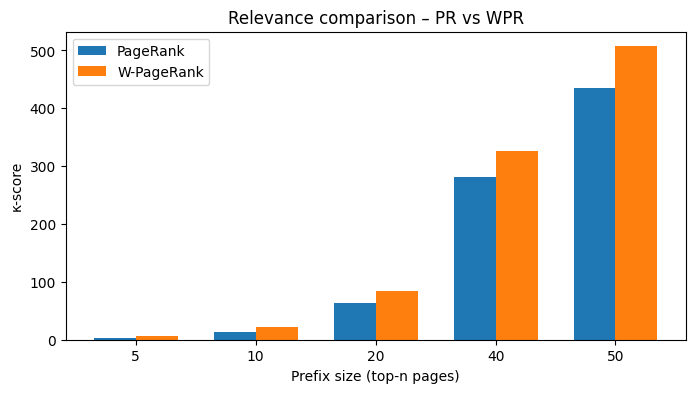

In [14]:
x = np.arange(len(cutoffs))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(x - width / 2, results["PR"]["kappa"], width, label="PageRank")
ax.bar(x + width / 2, results["WPR"]["kappa"], width, label="W-PageRank")

ax.set_xticks(x)
ax.set_xticklabels([str(c) for c in cutoffs])
ax.set_xlabel("Prefix size (top-n pages)")
ax.set_ylabel("κ-score")
ax.set_title("Relevance comparison – PR vs WPR")
ax.legend()
plt.show()


<h1>the end
